In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/weather_classification/dataset.zip" -d /content/
data_dir = "/content/dataset"

In [3]:
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"
val_dir = data_dir + "/validation"

In [4]:
%cd drive/MyDrive/weather_classification

/content/drive/MyDrive/weather_classification


In [7]:
!pip install tensorflow
!pip install keras

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train_gen = ImageDataGenerator(rescale=1/255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True,
                               vertical_flip = False,
                               fill_mode = 'reflect')

test_gen = ImageDataGenerator(rescale=1/255)

val_gen = ImageDataGenerator(rescale=1/255)

In [12]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
)
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
)
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
)

Found 1350 files belonging to 6 classes.
Found 296 files belonging to 6 classes.
Found 286 files belonging to 6 classes.


In [13]:
class_names = train_data.class_names
print(class_names)

['cloudy', 'rain', 'shine', 'snow', 'storm_fog', 'sunrise']


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
tf.__version__

'2.18.0'

In [24]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten, Conv2D, Input, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, layers

data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.2, 0.2)
])

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_tensor=x
)

fine_tune_at = 15

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

x = Dense(64)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(6)(x)
outputs = Activation('softmax')(outputs)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             

 Total params: 14,889,350 (56.80 MB)

 Trainable params: 7,253,190 (27.67 MB)

 Non-trainable params: 7,636,160 (29.13 MB)

In [26]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
            )

In [22]:
%ls

best_model.keras  dataset.zip  weather_classification.ipynb


In [27]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 4,
    restore_best_weights=True,
    min_delta=0.001,
)

checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/weather_classification/best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

model.fit(train_data,
          validation_data=val_data,
          epochs=50,
          callbacks=[checkpoint, early_stop])

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.1977 - loss: 2.2400
Epoch 1: val_loss improved from inf to 1.84213, saving model to /content/drive/MyDrive/weather_classification/best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.1981 - loss: 2.2375 - val_accuracy: 0.2657 - val_loss: 1.8421
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2628 - loss: 1.8733
Epoch 2: val_loss improved from 1.84213 to 1.52489, saving model to /content/drive/MyDrive/weather_classification/best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.2633 - loss: 1.8726 - val_accuracy: 0.3671 - val_loss: 1.5249
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.2949 - loss: 1.8087
Epoch 3: val_loss improved from 1.52489 to 1.38499, saving model to /content/drive/MyDrive/weather_classification/best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.2960 - loss: 1.8062 - val_accuracy: 0.4650 - val_loss: 1.3850


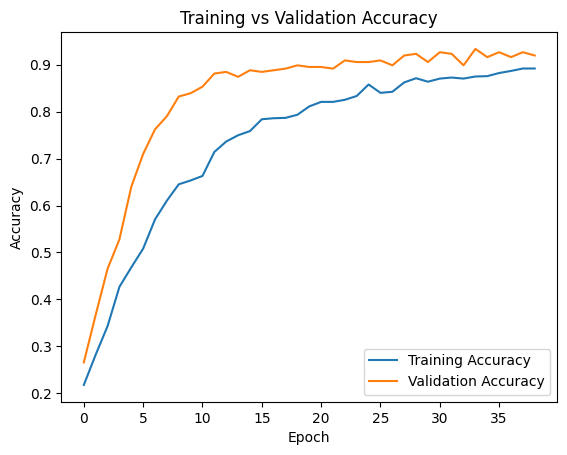

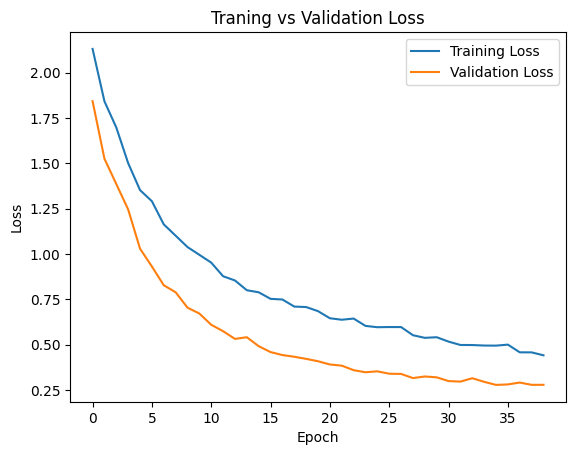

In [28]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Traning vs Validation Loss')
plt.show()

In [29]:
model.evaluate(test_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.8891 - loss: 0.3788


[0.38434475660324097, 0.8918918967247009]

In [30]:
import numpy as np

y_true = []
y_pred = []

for images, labels_batch in val_data:
    preds = model.predict(images)
    y_true.extend(labels_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


              precision    recall  f1-score   support

      cloudy     0.8519    0.9583    0.9020        48
        rain     0.9000    0.9375    0.9184        48
       shine     1.0000    0.8913    0.9425        46
        snow     0.8654    0.9375    0.9000        48
   storm_fog     0.8667    0.8298    0.8478        47
     sunrise     0.9773    0.8776    0.9247        49

    accuracy                         0.9056       286
   macro avg     0.9102    0.9053    0.9059       286
weighted avg     0.9100    0.9056    0.9059       286



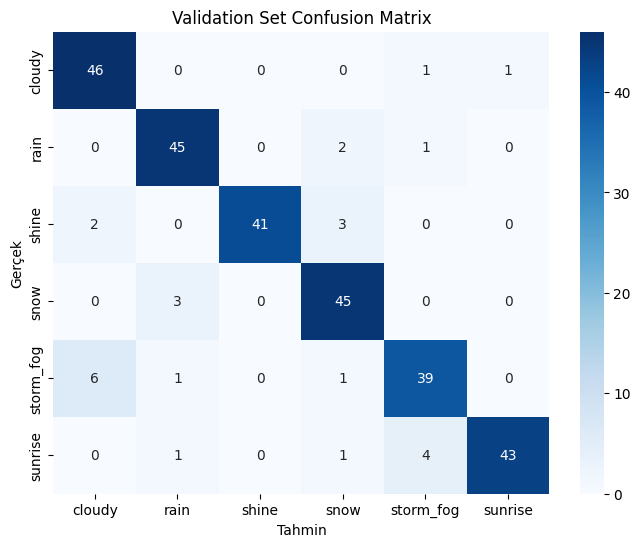

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Sınıf isimlerini güvenli şekilde al
labels = ["cloudy","rain","shine","snow","storm_fog","sunrise"]

# Classification Report
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Validation Set Confusion Matrix")
plt.show()
